In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

x_data_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"
y_data_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

x_data = pd.read_csv(x_data_file)
y_data = pd.read_csv(y_data_file)

X_data = x_data.values.astype(np.float32)
Y_data = y_data.values.astype(np.float32)

input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.2, random_state=42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) 
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)     
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

net = NeuralNetRegressor(
    module=NeuralNetwork,
    module__input_size=X_data.shape[1],
    module__hidden_size1=256,
    module__hidden_size2=256,
    module__hidden_size3=128,  
    module__output_size=Y_data.shape[1],
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.0005,
    max_epochs=3000,
    callbacks=[EarlyStopping(patience=20)],
    device='cuda' if torch.cuda.is_available() else 'cpu',  
)

history = net.fit(X_train, y_train)

train_losses = history.history[:, 'train_loss']
valid_losses = history.history[:, 'valid_loss']

y_pred = net.predict(X_test)

y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

torch.save(net.module_.state_dict(), 'trained_model.pth')

net.module_.load_state_dict(torch.load('trained_model.pth'))
net.module_.eval()

X_example = X_test[0]
X_example_tensor = torch.tensor(X_example, dtype=torch.float32)
with torch.no_grad():
    prediction = net.module_(X_example_tensor.unsqueeze(0))  

prediction_original = target_scaler.inverse_transform(prediction.numpy())

predicted_parameters = prediction_original[0].tolist()
print(f'Predicted c-parameters:')
print(prediction_original[0].tolist())

# val error usually around 0.04
# r-squared value usually around 0.5 


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1033        0.0788  0.1780
      2        0.0777        0.0777  0.1783
      3        0.0769        0.0771  0.1690
      4        0.0764        0.0767  0.1701
      5        0.0759        0.0763  0.1725
      6        0.0754        0.0759  0.1706
      7        0.0749        0.0750  0.1739
      8        0.0744        0.0743  0.1864
      9        0.0738        0.0739  0.1934
     10        0.0732        0.0732  0.1693
     11        0.0729        0.0728  0.1654
     12        0.0726        0.0726  0.1698
     13        0.0724        0.0724  0.1733
     14        0.0722        0.0723  0.1815
     15        0.0720        0.0721  0.1722
     16        0.0719        0.0720  0.1734
     17        0.0717        0.0718  0.1655
     18        0.0716        0.0717  0.1652
     19        0.0715        0.0715  0.1718
     20        0.0714        0.0715  0.1740
     21        0.0713        0.0

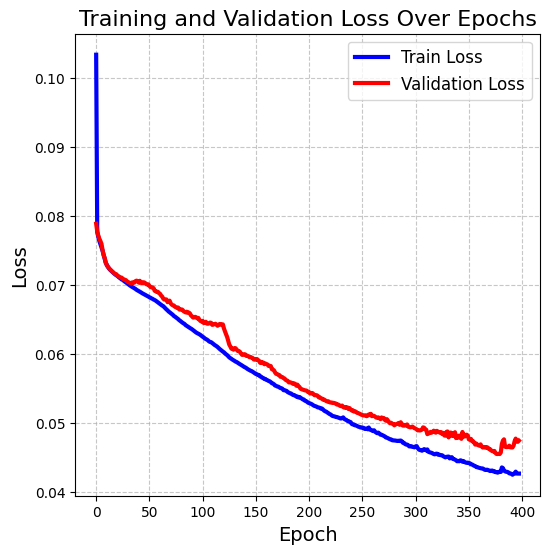

In [2]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss', linestyle='-', color='blue', linewidth=3)
plt.plot(valid_losses, label='Validation Loss', linestyle='-', color='red', linewidth=3)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

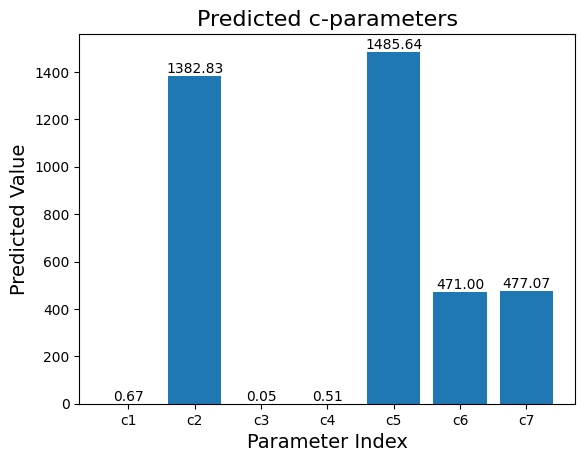

In [3]:
# Plot the predicted c-parameters in a bar chart
parameter_labels = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

plt.bar(parameter_labels, predicted_parameters)
plt.xlabel('Parameter Index', fontsize=14) 
plt.ylabel('Predicted Value', fontsize=14)  
plt.title('Predicted c-parameters', fontsize=16)  

# Add text labels for each bar
for i, value in enumerate(predicted_parameters):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [4]:
# Define the desired ranges for the second and sixth variables
fourth_variable_range = [0.04, 0.17]
sixth_variable_range = [700, 1500]

# Create a copy of the original predicted c-parameters
prediction_adjusted = np.copy(prediction_original)

# Ensure the second variable is within the desired range
prediction_adjusted[0, 3] = np.clip(prediction_adjusted[0, 3], *fourth_variable_range)

# Ensure the sixth variable is within the desired range
prediction_adjusted[0, 5] = np.clip(prediction_adjusted[0, 5], *sixth_variable_range)

# Print the predicted 'c-parameters' with adjusted values
print(f'Predicted c-parameters with adjusted values:')
print(prediction_adjusted[0].tolist()) 

Predicted c-parameters with adjusted values:
[0.6693037152290344, 1382.8306884765625, 0.048769451677799225, 0.17000000178813934, 1485.639892578125, 700.0, 477.0671081542969]


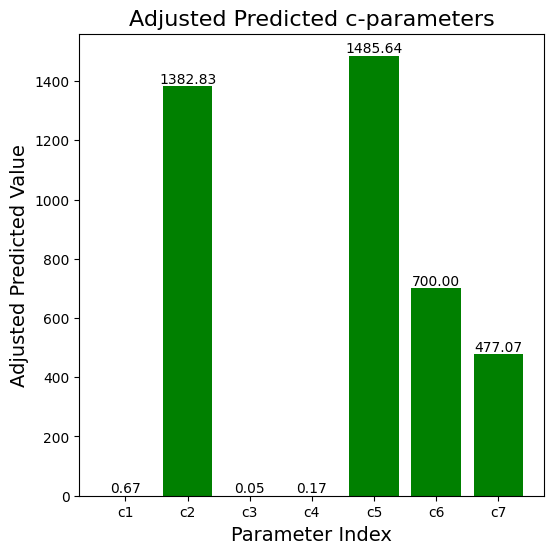

In [5]:
# Plot the adjusted predicted c-parameters in a bar chart
parameter_labels = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

plt.figure(figsize=(6, 6))
plt.bar(parameter_labels, prediction_adjusted[0], color='green')
plt.xlabel('Parameter Index', fontsize=14)
plt.ylabel('Adjusted Predicted Value', fontsize=14)
plt.title('Adjusted Predicted c-parameters', fontsize=16)

# Add text labels for each bar  (predicted values)
for i, value in enumerate(prediction_adjusted[0]):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [7]:
np.save('loss_values_25C.npy', {'train': train_losses, 'valid': valid_losses})
